# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

#### Описание данных
</b>airports_nearest — расстояние до ближайшего аэропорта в метрах (м)  
    balcony — число балконов  
    ceiling_height — высота потолков (м)  
    cityCenters_nearest — расстояние до центра города (м)  
    days_exposition — сколько дней было размещено объявление (от публикации до снятия)  
    first_day_exposition — дата публикации  
    floor — этаж  
    floors_total — всего этажей в доме  
    is_apartment — апартаменты (булев тип)  
    kitchen_area — площадь кухни в квадратных метрах (м²)  
    last_price — цена на момент снятия с публикации  
    living_area — жилая площадь в квадратных метрах(м²)  
    locality_name — название населённого пункта  
    open_plan — свободная планировка (булев тип)  
    parks_around3000 — число парков в радиусе 3 км  
    parks_nearest — расстояние до ближайшего парка (м)  
    ponds_around3000 — число водоёмов в радиусе 3 км  
    ponds_nearest — расстояние до ближайшего водоёма (м)  
    rooms — число комнат  
    studio — квартира-студия (булев тип)  
    total_area — площадь квартиры в квадратных метрах (м²)  
    total_images — число фотографий квартиры в объявлении

## План исследования

1. Ознакомление с данными.  
2. Предобработка данных.  
    2.1 Определяем пропущенные значения.  
    2.2 Заполняем пропуски.   
    2.3 Приводим данные к необходимым типам.
3. Добавление в таблицу.  
    3.1 Цену квадратного метра  
    3.2 День недели, месяц и год публикации объявления  
    3.3 Этаж квартиры  
    3.4 Соотношение жилой и общей площади  
    3.5 Соотношение площади кухни к общей  
4. EDA  
    4.1 Находим выбросы и ошибки. Ошибки удаляем.  
    4.2 Изучаем зависимость стоимости недвижимости от различных факторов   
    4.3 Создаём рейтинг топ-10 городов с объявлениями  
    4.4 Выделяем центральную область Санкт-Петербурга  
    4.5 Изучаем зависимость стоимости недвижимости в центре от различных факторов  
5. Общий вывод

## <span style="color:blue">Changelog 10.07.2020 
- Пропуски по количеству дней показа объявления оставлены нетронутыми
- Зависимость стоимости недвижимости от числа комнат выражена боксплотами, а не диаграммой рассеяния
- Добавлен графический анализ зависимостей стоимости недвижимости от даты публикации объявления
- Выбросы удалены только по параметрам "цена" и "площадь", остальные параметры не являются ключевыми, определяющими стоимость квартир

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
real_estate = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
real_estate.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


На первый взгляд слишком много данных NaN

Посмотрим общую информацию по датафрейму

In [4]:
real_estate.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


Что бросается в глаза:
- Максимальная цена в 763 млн руб
- 19 - комнатные квартиры
- 100-метровые потолки


Выведем информацию с типом данных:

In [5]:
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Огромное количество NaN. Посмотрим сколько.

In [6]:
real_estate.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

И проверим на дубликаты.

По всем признакам:

In [7]:
real_estate.duplicated().sum()

0

И поcмотрим может быть есть разные написания одних и тех же населённых пунктов:

In [8]:
locality = real_estate['locality_name'].sort_values().unique()
locality

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Есть одинаковые названия с е и ё. Есть названия типа "Кудрово" и "деревня Кудрово"

### Итак:
- Явных дубликатов в данных нет. Нужно будет проверить еще раз на этапе заполнения пропусков и после него.
- Пропусков очень много. Остановимся подробнее.
- <font color=#333ff>is_apartment</font>  – тут всё запутано. Вероятно причина может крыться в том, что само понятие апартаментов многими неверно истолковывается. Апapтaмeнты — это фактически коммерческая недвижимость, но мало кто об этом знает. Т.е. скорее всего при заполнении формы большинство просто пропускало этот  вопрос, по причине того что не особо понимали его.
- <font color=#333ff>ceiling_height</font> – тоже много отсутствующих значений. Возьмусь предположить, что многие просто не считают эту информацию важной и попросту её пропускают. 
- <font color=#333ff>balcony</font> – возможно пропуски там, где балкон отсутствует. Необходимо проверить, что в столбце balcony значений 1 это "есть балкон", а 0 "нет балкона"
- <font color=#333ff>days_exposition</font> - информация может отсутствовать, например, по причине того, что неизвестно когда было закрыто объявление о продаже, т.е., сделка была совершена, но не была закрыта на онлайн-ресурсе. По той же причине можем получить результаты в виде срока продажи квартиры в несколько лет. Тем не менее, проставлять информацию о сроках продажи наугад не стоит. Здесь среднее/медиана не подойдут. Поэтому оставим этот столбец в покое.

- Пропусков в <font color=#333ff>parks_nearest, ponds_nearest</font> В целом, это далеко не самые важные параметры, плюс отсутствует возможность проставить какое-либо адекватное расстояние, которое не испортит статистику по уже присутствующим данным в этих столбцах. Предлагаю здесь не трогать пропуски, учитывая, что есть достаточное количество строк, где данные присутствуют, и по ним можно сделать срез и заметить определенные тенденции;
- В <font color=#333ff>localty_name</font> тоже хватает пропусков. Хотя странно, когда не указан населённый пункт. Предположу, что может быть если речь идёт про Питер и квартира находится в самом Питере, то продавец автоматически не считает необходимым это ещё раз указывать. Плюс в названиях населенных пунктов встречается разное написание слова поселок – с е и ё. !!!UPD для ответов на поставленные вопросы нам этот столбец не требуется. Оставим как есть.

### Вывод: данные далеко не "чистые", будем приводить их в порядок.

### Шаг 2. Предобработка данных

Заполним пропуски. 

##### is_aparment

In [9]:
real_estate['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Присутствуют значения и False и True. Тем не менее заполнять пропуски каким-то одним значением мы не будем. Это явно исказить данные.

##### balcony  
Примерно половина записей содержит пропуски. Вполне вероятно, что у недвижимости просто нет балконов. К слову, лоджия – это уже часть жилого помещения. Заполним пропуски 0.

In [10]:
real_estate['balcony'] = real_estate['balcony'].fillna(0)

##### ceiling_height  
9 195 пропуска. В среднем, этот параметр должен колебаться в пределах 2.4 - 3.2 м. Минимальная высота потолка определяется строительными нормами и правилами в 2.4 м. На этапе EDA детальнее изучим данные и при необходимости почистим их.

##### living_area

living_area - 1 903 пропуска. 

Заполнить пропуски медианой – не совсем правильное решение, т.к. медиана может быть больше общей площади квартиры.

Проверим не являются ли пропуски характерными для апартаментов или студий, где жилая площадь не так очевидна или пользователи просто не добавили данные.

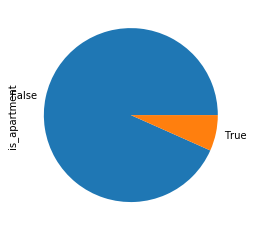

In [11]:
missing_living_area = real_estate[real_estate['living_area'].isnull()]
missing_living_area['is_apartment'].value_counts().plot(kind='pie')
plt.show()

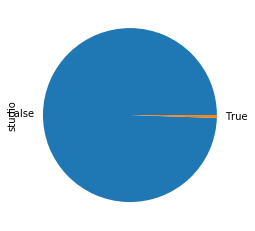

In [12]:
missing_living_area['studio'].value_counts().plot(kind='pie')
plt.show()

In [13]:
#гипотеза не подтвердилась, заполняем медианой
real_estate.loc[real_estate['living_area'].isnull(), 'living_area'] = real_estate['living_area'].median()

##### days_exposition
days_exposition (3 181) – сколько дней было размещено объявление (от публикации до снятия). На эти пропуски мы могли бы указать разработчикам портала недвижимости. Допустим, ограничить срок размещения объявления конкретным сроком или что-то вроде того. Для восстановления пропусков у нас нет подходящего признака, поэтому заполним их опять медианой. Проверим распределение на этапе EDA.

In [14]:
#оставим пропуски по количеству дней показа объявления нетронутыми
#real_estate.loc[real_estate['days_exposition'].isnull(), 'days_exposition'] = real_estate['days_exposition'].median()

##### first_day_exposition
first_day_exposition приведем к к формату %Y-%m-%d:

In [15]:
real_estate['first_day_exposition'] = pd.to_datetime(real_estate['first_day_exposition'], format='%Y-%m-%d')

##### airports_nearest  и cityCenters_nearest 
Часть пропусков airports_nearest (5 542) и cityCenters_nearest (5 519) попробуем заполнить медианой по срезу данных по населенному пункту. Но как мы видим, для некоторых записей восстановить пропуски мы не сможем. В этих случаях, скорее всего нет картографических данных для рассчета расстояний.

In [16]:
nearest_median = real_estate.pivot_table(
    index='locality_name',
    values=['airports_nearest', 'cityCenters_nearest'],
    aggfunc='median'
)

In [17]:
nearest_median

,airports_nearest,cityCenters_nearest
locality_name,,
Зеленогорск,72282.0,53381.0
Колпино,26232.0,32018.0
Красное Село,25715.5,29140.5
Кронштадт,67850.0,49575.0
Ломоносов,48415.5,51677.0
Павловск,20529.5,32683.0
Петергоф,39231.0,33771.0
Пушкин,15766.0,27930.5
Санкт-Петербург,26757.5,12244.5


In [18]:
nearest_median_locality = list(nearest_median.index)

In [19]:
def fill_locality(row, col):
    localities = row['locality_name']
    
    if localities in nearest_median_locality:
        return nearest_median.loc[localities][col]
    
    return row[col]

In [20]:
columns = ['airports_nearest', 'cityCenters_nearest']
for column in columns:
    real_estate.loc[real_estate[column].isnull(), column] = real_estate.apply(fill_locality, axis=1, args=(column,))

In [21]:
# Проверим данные по скольким населенные пунктам не удалось заполнить
len(real_estate[real_estate['cityCenters_nearest'].isnull()]['locality_name'].unique())

337

В любом случае это гораздо лучше, чем 5 с лишним тысяч!

##### floors_total
floors_total – всего этажей в доме. Можно предположить, что там где пропуски это одноэтажные дома. Заполним пропуски значением 1. Даже если наше предположение ошибочно, 86 записей не должны сильно исказить данные.

In [22]:
real_estate['floors_total'] = real_estate['floors_total'].fillna(1)

### Приведём данные к нужному типу

Сначала взглянем ещё раз на таблицу

In [23]:
real_estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,30.0,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


- last_price - переведём в целочисленный тип;
- total_area - округлим до 1- го знака после запятой;
- ceiling_height, living_area, kitchen_area - округлим до 1 -го знака после запятой;
- floors_total, balcony - Однозначно в int.
- airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest - все расстояния указаны в метрах, переведём в целочисленный формат.
- days_exposition - количество дней, как долго продавалась недвижимость. Тоже переведём в int.

Список столбцов для приведения в целочисленный тип

In [24]:
list_to_int = ['last_price', 'floors_total', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
               'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']
for column in list_to_int:
    real_estate[column] = real_estate[real_estate[column].notnull()][column].astype('int')

Список столбцов для приведения в вещественный тип

In [25]:
list_to_float = ['total_area', 'ceiling_height', 'living_area', 'kitchen_area']
for column in list_to_float:
    real_estate[column] = real_estate[real_estate[column].notnull()][column].round(1)

Взглянем на результат.

In [26]:
real_estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,NaN,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,NaN,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,NaN,14,30.0,9,NaN,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.0,14,32.0,13,NaN,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Типы данных в порядке.

### Шаг 3. Посчитайте и добавьте в таблицу

#### Считаем цену квадратного метра

In [27]:
real_estate['price_square_meter'] = real_estate['last_price'] / real_estate['total_area']

#### Добавляем день недели, месяц и год публикации объявления

In [28]:
#день
real_estate['day_exposition'] = real_estate['first_day_exposition'].dt.dayofweek
#месяц
real_estate['month_exposition'] = real_estate['first_day_exposition'].dt.month
#год
real_estate['year_exposition'] = real_estate['first_day_exposition'].dt.year

#### Добавляем этаж квартиры (варианты -- первый, последний, другой)

In [29]:
def categorize_floor(row):
    """Категоризация этажей"""

    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
    
real_estate.loc[:, 'floor'] = real_estate.apply(categorize_floor, axis=1)

In [30]:
real_estate['floor'].value_counts()

другой       17446
последний     3336
первый        2917
Name: floor, dtype: int64

#### Соотношение жилой и общей площади

In [31]:
real_estate['living_total_areas_ratio'] = real_estate['living_area'] / real_estate['total_area']

#### Соотношение площади кухни к общей

In [32]:
real_estate['kitchen_total_areas_ratio'] = real_estate['kitchen_area'] / real_estate['total_area']

Смотрим, что получилось

In [33]:
real_estate.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,day_exposition,month_exposition,year_exposition,living_total_areas_ratio,kitchen_total_areas_ratio
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,другой,NaN,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,первый,NaN,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,другой,NaN,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,NaN,14,30.0,другой,NaN,...,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,0.188679,NaN
4,2,10000000,100.0,2018-06-19,2,3.0,14,32.0,другой,NaN,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,0.320000,0.410000
5,10,2890000,30.4,2018-09-10,1,NaN,12,14.4,другой,NaN,...,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,0.473684,0.299342
6,6,3700000,37.3,2017-11-02,1,NaN,26,10.6,другой,NaN,...,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,0.284182,0.386059
7,5,7915000,71.6,2019-04-18,2,NaN,24,30.0,другой,NaN,...,NaN,0.0,NaN,NaN,110544.692737,3,4,2019,0.418994,0.263966
8,20,2900000,33.2,2018-05-23,1,NaN,27,15.4,другой,NaN,...,NaN,NaN,NaN,189.0,87349.397590,2,5,2018,0.463855,0.265060
9,18,5400000,61.0,2017-02-26,3,2.5,9,43.6,другой,NaN,...,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,0.714754,0.106557


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### Проверим выбросы

#### Площадь

Выведем информацию по нужному столбцу

In [34]:
real_estate['total_area'].describe()

count    23699.000000
mean        60.348635
std         35.654086
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

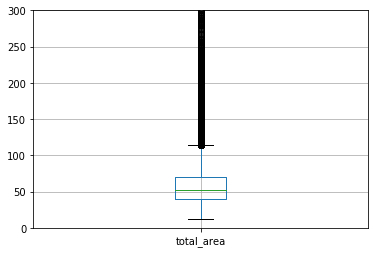

In [35]:
#для наглядности построим "ящик с усами"
plt.ylim(0, 300)
real_estate.boxplot('total_area')
plt.show()

- Большая часть значений лежит в диапазоне от 40 до 70 кв.м.
- Нижний "ус" упирается в минимальное значение равное 12. Пожалуй, есть и такие варианты помещений.
- Верхний "ус" на значении около 115 кв.м.
- Все, что лежит за границей нормального размаха, считаем выбросом.  
- Таким образом, нам нужен будет диапазон от 12 до 115 кв.м.

Посмотрим на гистограмму

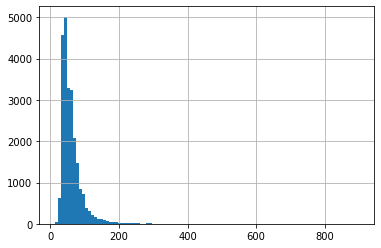

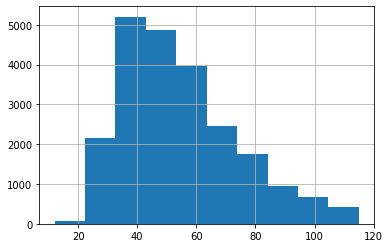

In [36]:
#исходные данные
real_estate['total_area'].hist(bins=100)
plt.show()
#данные без выбросов 
real_estate.query('total_area >= 12 and total_area <= 115')['total_area'].hist()
plt.show()

Самый популярный метраж ~35-55 м2

### Цена

По такой же аналогии исследуем цену

In [37]:
real_estate['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

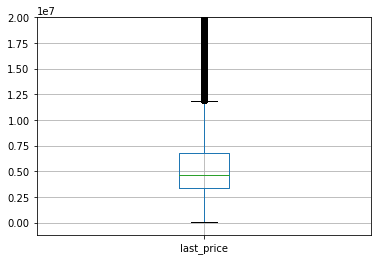

In [38]:
plt.ylim(-1.2e+06, 2e+07)
real_estate.boxplot('last_price')
plt.show()

- Большая часть значений лежит в диапазоне примерно от 3,5 до 7 млн. Вроде бы адекваттные цифры.
- Нижний "ус" упирается в 0... Минимум равен 12 190, в то время как средняя стоимость недвижимости – 6.5 млн. Очень странно.

Рассмотрим подробнее:

In [39]:
#взглянем на цены, предположим, менее полумиллиона
cheap_real_estate = real_estate.query('last_price < 5e+5')
cheap_real_estate.sort_values('last_price').head()[['locality_name', 'last_price', 'total_area']]

,locality_name,last_price,total_area
8793,Санкт-Петербург,12190,109.0
14911,посёлок станции Свирь,430000,54.0
17456,Сланцы,430000,30.4
16274,деревня Старополье,440000,40.0
5698,городской посёлок Будогощь,450000,42.0


12 тысяч рублей за 100 квадратных метров в Питере. Заманчиво, но какая-то ерунда.

А вот полмиллиона за 30-40 квадратов в деревнях скорее всего правдоподобно.

Отметим нижнюю границу данных в 430 000 тыс.

Согласно диаграмме размаха, верхний ус на отметке около 12млн. Данные выше этого значения считаются выбросами. Но ведь есть много недвижимости с запредельными ценами, что тоже является нормой.

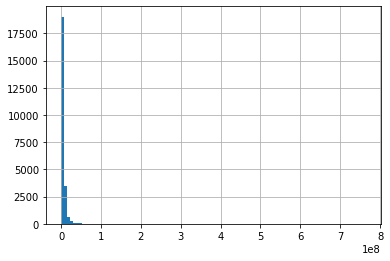

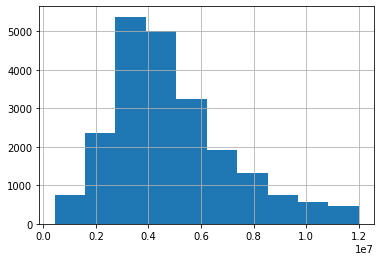

In [40]:
#исходные данные
real_estate['last_price'].hist(bins=100)
plt.show()
#данные без выбросов
real_estate.query('last_price >= 4.3e+5 and last_price <= 1.2e+7')['last_price'].hist()
plt.show()

Большинство недвижимости колеблется в пределах цены 3-5 млн. руб.

### Число комнат

In [41]:
real_estate['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

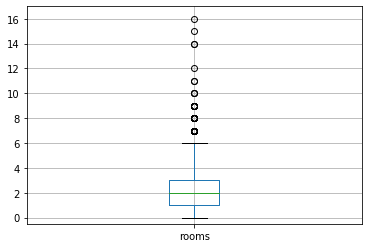

In [42]:
plt.ylim(-0.5, 17)
real_estate.boxplot('rooms')
plt.show()

Большая часть значений лежит в диапазоне 1-3 комнаты. Это ок.
Нижний "ус" упирается в 0. Но ведь бывают, например студии. Фактически там нет комнат. 
Верхний "ус" заканчивается около 6.
Выбросы лежат за ориентировочной границей нормального распределения. <font color=#333ff>!UPD.</font> Оставим их в покое и не станем удалять

### Высота потолков

In [43]:
real_estate['ceiling_height'].describe()

count    14504.000000
mean         2.775717
std          1.260951
min          1.000000
25%          2.500000
50%          2.600000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

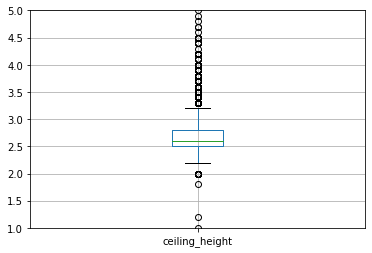

In [44]:
plt.ylim(1, 5)
real_estate.boxplot('ceiling_height')
plt.show()

- Большая часть значений лежит в диапазоне от 2.5 до 2.8 м.
- Нижний "ус" упирается в 2.2 м. 
- Верхний "ус" заканчивается около 3.2 м.

Минимальная высота потолка по нормам составляет 2.4 м. В новостройках высота потолков в среденем колеблется от 2.4 до 2.7 м. В сталинках и элитном жилье может превышать 3.2 м. <font color=#333ff>!UPD.</font>Ну пусть превышает, мало ли у кого какие проектные фантазии...

### Время продажи

In [45]:
real_estate['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

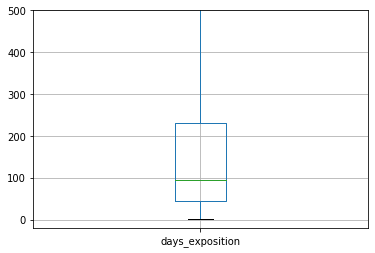

In [46]:
plt.ylim(-20, 500)
real_estate.boxplot(column='days_exposition')
plt.show()

- Большая часть значений лежит в диапазоне от 45 до 200 дней. Хотя мне всегда казалось, что за 1,5 месяца что-то продать нереально. Но всё может быть.
- Нижний "ус" упирается в 1, минимальное значение. Это вряд ли может быть правдой.
- Верхний "ус" заканчивается на отметке около 430 дней.  
</b>Что имеем:
- продажа обычно занимает около 100 дней;
- продажа в течение <50 дней – мне кажется это слишком быстро. Но на всякий случай возьмём за точку отсчёта длительность в месяц.
- дольше 200 дней – долго, но по личному опыту квартиру запросто можно продавать и год. <font color=#333ff>!UPD.</font> Пожалуй, оставим тут всё как есть.

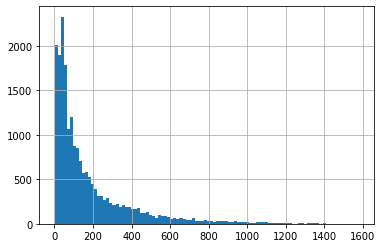

In [47]:
#исходные данные
real_estate['days_exposition'].hist(bins=100)
plt.show()


Что ж, выглядит всё вполне правдоподобно, на мой взгляд. В большинстве случаев квартиры продаются за 3 месяца.

#### Факторы, влияющие на стоимость квартиры


Факторы будем рассматривать в контексте данных, прошедших очистку на предыдущих этапах. Для срезов у нас будут следующие условия:

In [48]:
total_area_query = 'total_area >= 12 and total_area <= 115'
last_price_query = 'last_price >= 4.3e+5 and last_price <= 1.2e+7'
rooms_query = 'rooms >= 1'

##### Зависимость стоимости недвижимости от квадратного метра:

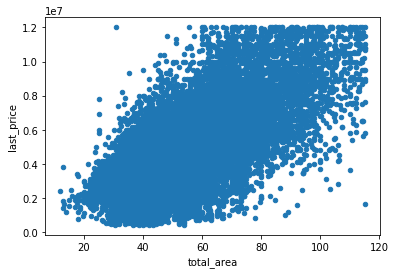

In [84]:
#построим диаграмму рассеяния
good_data_query = f'{total_area_query} and {last_price_query}'
good_data = real_estate.query(good_data_query)

good_data.plot(x='total_area', y='last_price', kind='scatter')
plt.show()

In [50]:
### Код ревьювера ###

len(good_data) / len(real_estate)

0.9099540064981645

In [51]:
#и посмотрим на коэффициент корреляции
good_data['total_area'].corr(good_data['last_price'])

0.700477268020349

По графикам и коэффициенту корреляции видим, что взаимосвязь между количеством квадратных метров и стоимостью недвижимости есть.

##### Зависимость стоимости недвижимости от числа комнат

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


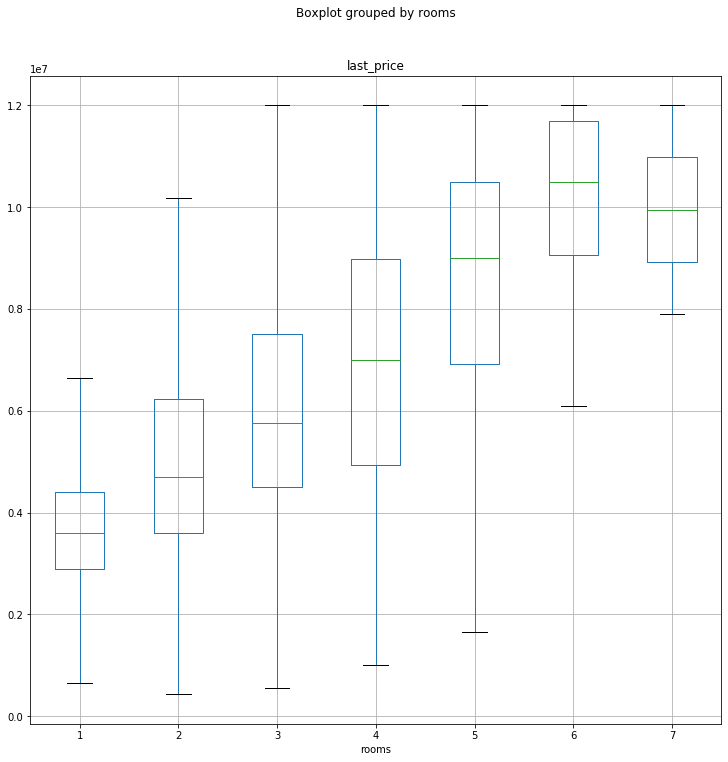

In [52]:
#построим боксплоты
good_data_query = f'{rooms_query} and {last_price_query}'
good_data = real_estate.query(good_data_query)

good_data.boxplot('last_price', by='rooms', showfliers=False, figsize=(12,12))
plt.show()

Чем больше комнат - тем выше цена. Ничего необычного.

In [53]:
#и посмотрим на коэффициент корреляции
good_data['rooms'].corr(good_data['last_price'])

0.45243838465847797

 Видим слабую завимисоть между количеством комнат и стоимостью недвижимости.

##### Зависимость стоимости недвижимости от этажа

In [54]:
#посмотрим на срез
real_estate[['floor', 'last_price']].query(last_price_query).pivot_table(index='floor', values='last_price')

,last_price
floor,
другой,5.072145e+06
первый,4.160474e+06
последний,4.533718e+06


Как и предполагалось, первый этаж – самый дешевый, к последнему, как правило у многих предвзятое отношение, зато этажи между пользуются популярностью.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


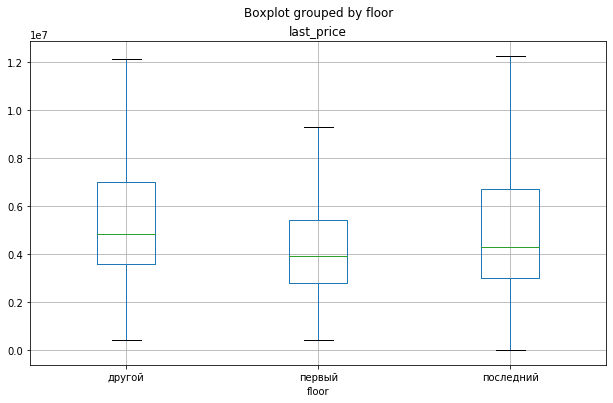

In [55]:
### Код ревьювера ###

real_estate.boxplot('last_price', by='floor', showfliers=False, figsize=(10,6))

##### Зависимость стоимости недвижимости от удалённости от центра

Построим гистограмму

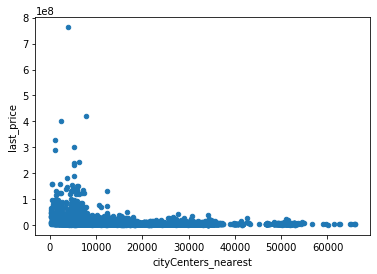

In [56]:
good_data = real_estate.query(last_price_query)
real_estate.plot(x='cityCenters_nearest', y='last_price', kind='scatter')
plt.show()

И посмотрим на корреляцию

In [57]:
good_data['cityCenters_nearest'].corr(good_data['last_price'])

-0.35229913857412937

Видим, что есть слабая взаимосвязь между расстоянием от центра и ценой – чем ближе к центру, тем  дороже.

##### Зависимость стоимости недвижимости от даты публикации объявления

Выведем таблицу корреляции

In [58]:
good_data[['day_exposition', 'month_exposition', 'year_exposition', 'last_price']].corr()

,day_exposition,month_exposition,year_exposition,last_price
day_exposition,1.000000,0.011688,-0.004048,-0.014793
month_exposition,0.011688,1.000000,-0.266269,0.005394
year_exposition,-0.004048,-0.266269,1.000000,-0.005461
last_price,-0.014793,0.005394,-0.005461,1.000000


И построим таблицы рассеяния для размещения объявлений по дням, месяцам и годам

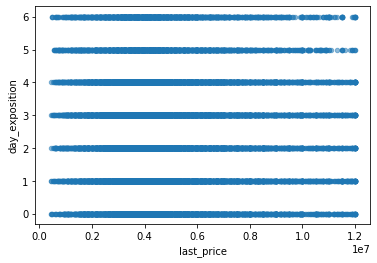

In [59]:
good_data.plot(x='last_price', y='day_exposition', kind='scatter', alpha=0.5)

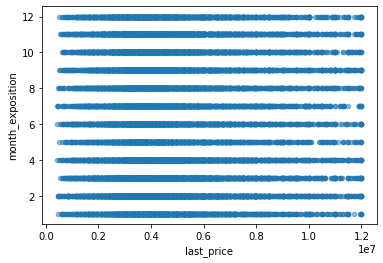

In [60]:
good_data.plot(x='last_price', y='month_exposition', kind='scatter', alpha=0.5)

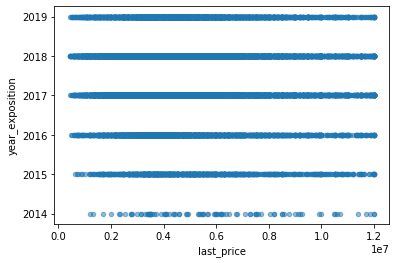

In [61]:
good_data.plot(x='last_price', y='year_exposition', kind='scatter', alpha=0.5)

> **_<span style="color:blue">Что-то такое требовалось?</span>_**

> **_<span style="color:blue">Или нагляднее так?↓</span>_**

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


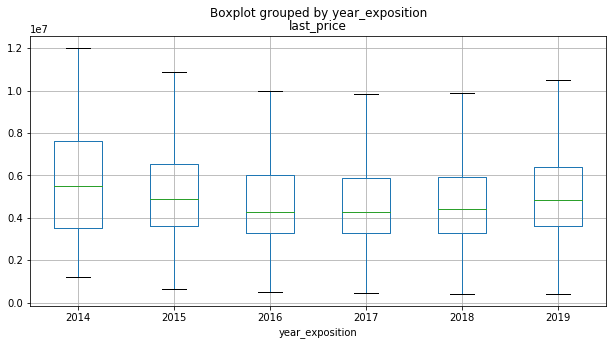

In [62]:
good_data.boxplot('last_price', by='year_exposition', showfliers=False, figsize=(10,5))

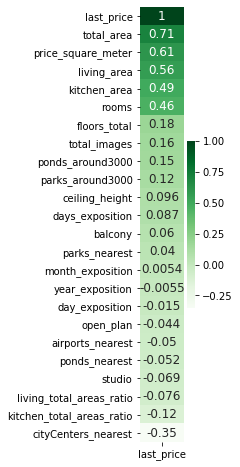

In [63]:
import seaborn as sns
plt.figure(figsize=(1,8))
sns.heatmap(good_data.corr()[['last_price']].sort_values(by='last_price', ascending=False), cmap="Greens", 
            annot=True, annot_kws={'size':12})

Как мы видим, особенной связи между датой публикации объявления и стоимостью недвижимости нет. Ну разве что в 15-м году недвижимость продавалась из рук вон плохо. Может кризис какой был.

In [64]:
### Код ревьювера ###

len(good_data) / len(real_estate)

0.9180556141609351

##### 10 населённых пунктов с наибольшим числом объявлений

In [65]:
top10_locality = real_estate['locality_name'].value_counts().head(10)
top10_locality

Санкт-Петербург      15721
посёлок Мурино         522
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64

Посчитаем цену квадратного метра и выведем рейтинг:

In [66]:
top10_locality = real_estate['locality_name'].value_counts().index.tolist()[:10]
mean10_metrics = [real_estate[real_estate['locality_name'] == city]['price_square_meter'].
                  median().round(2) for city in top10_locality]
mean10_prices = [real_estate[real_estate['locality_name'] == city]['last_price'].median() for city in top10_locality]
frame = {'Город': top10_locality, 'Средняя цена за кв.м., тыс. руб.': mean10_metrics,
         'Средняя цена за квартиру, тыс. руб.': mean10_prices}
dataframe = pd.DataFrame(frame).sort_values(by='Средняя цена за кв.м., тыс. руб.', ascending=False)
dataframe

,Город,"Средняя цена за кв.м., тыс. руб.","Средняя цена за квартиру, тыс. руб."
0,Санкт-Петербург,104761.90,5500000.0
4,Пушкин,100000.00,5180000.0
8,деревня Кудрово,91860.47,3790000.0
6,посёлок Парголово,91642.86,4100000.0
1,посёлок Мурино,85890.22,3400000.0
2,посёлок Шушары,76876.17,3950000.0
5,Колпино,74723.75,3600000.0
7,Гатчина,67796.61,3100000.0
3,Всеволожск,65789.47,3450000.0
9,Выборг,58158.32,2897000.0


В Санкт-Петербурге самая высокая цена за квадратный метр. В Выборге – самая низкая. Чем дальше - тем дешевле, стандартно.

### Недвижимость в Санкт-Петербурге

Изучим предложения квартир. Для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге (locality_name). Задача — выяснить, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. После этого посчитаем среднюю цену для каждого километра. Построим график: он будет показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.

In [67]:
#выберем всю недвижимость города
spb = pd.DataFrame(real_estate.loc[real_estate['locality_name'] == "Санкт-Петербург"])
spb.reset_index()
len(spb)

15721

Посмотрим что из этого входит в центр

In [68]:
# Создадим столбец с расстоянием до центра в километрах округляя до целых значений
km = 1000
spb['from_center_km'] = (spb['cityCenters_nearest'] / km).astype('int')

Посчитаем среднюю цену для каждого километра удаленности:

In [69]:
spb_prices = spb.query(last_price_query)
spb_prices.pivot_table(index='from_center_km', values='last_price')

,last_price
from_center_km,
0,8.429409e+06
1,8.396685e+06
2,7.721342e+06
3,7.598287e+06
4,7.856875e+06
5,7.446107e+06
6,6.887989e+06
7,6.765614e+06
8,6.353700e+06


Построим график, который показывает как цена зависит от удалённости от центра

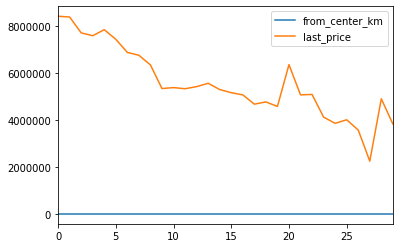

In [70]:
pd.DataFrame(spb_prices.pivot_table(index='from_center_km', values='last_price').
             to_records()).plot()
plt.show()

Видим границу, где график сильно меняется (~7 км)— это и будет центральная зона

Выделим сегмент недвижимости в центре:

In [71]:
realty_center = pd.DataFrame(spb_prices.query('from_center_km <= 7'))
len(realty_center)

2503

Проанализируем эти 2 503 объектов недвижимости. Для начала изучим параметры.

In [72]:
# площадь
realty_center.query(total_area_query)['total_area'].describe()

count    2402.000000
mean       64.638385
std        21.137401
min        12.000000
25%        47.100000
50%        63.050000
75%        79.800000
max       115.000000
Name: total_area, dtype: float64

In [73]:
# цена
realty_center['last_price'].describe()

count    2.503000e+03
mean     7.502496e+06
std      2.262249e+06
min      1.600000e+06
25%      5.800000e+06
50%      7.400000e+06
75%      9.150000e+06
max      1.200000e+07
Name: last_price, dtype: float64

In [74]:
# число комнат
realty_center.query(rooms_query)['rooms'].describe()

count    2487.000000
mean        2.378368
std         1.042337
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: rooms, dtype: float64

Больше объявлений по двушкам и трешкам.

In [75]:
# высота потолков
ceiling_height_query = 'ceiling_height >= 2.4'
realty_center.query(ceiling_height_query)['ceiling_height'].describe()

count    1606.000000
mean        3.046700
std         1.000884
min         2.400000
25%         2.800000
50%         3.000000
75%         3.200000
max        32.000000
Name: ceiling_height, dtype: float64

Средняя высота потолков ~3 м. 

Посмотрим на факторы, влияющие на стоимость квартиры(число комнат, удалённость от центра, дата размещения объявления):

In [76]:
# Ранее мы уже сделали срез по квартирам в центре Питера с учетом границы нормального размаха цены.
# Добавим остальные критерии, влияющие на чистоту данных, и сделаем окончательный срез на их основе.
good_data_query = f'{total_area_query} and {rooms_query}'
good_data = realty_center.query(good_data_query)


In [77]:
factors = [
    'last_price',
    'from_center_km',
    'floor',
    'rooms',
    'day_exposition',
    'month_exposition',
    'year_exposition'
]

good_data[factors].corr().sort_values('last_price', ascending=False)

,last_price,from_center_km,rooms,day_exposition,month_exposition,year_exposition
last_price,1.000000,-0.160835,0.439835,0.020457,-0.015590,0.008826
rooms,0.439835,-0.181794,1.000000,-0.024913,0.018343,-0.049884
day_exposition,0.020457,0.020792,-0.024913,1.000000,0.032453,0.003849
year_exposition,0.008826,0.037868,-0.049884,0.003849,-0.231923,1.000000
month_exposition,-0.015590,-0.004806,0.018343,0.032453,1.000000,-0.231923
from_center_km,-0.160835,1.000000,-0.181794,0.020792,-0.004806,0.037868


In [78]:
### Код ревьювера ###

(good_data.corr()['last_price']
                 .to_frame()
                 .sort_values('last_price', ascending=False)
                 .style.background_gradient(cmap='Reds')
)

,last_price
last_price,1
total_area,0.699859
living_area,0.535176
rooms,0.439835
kitchen_area,0.414717
price_square_meter,0.258243
days_exposition,0.140572
ceiling_height,0.107673
total_images,0.0961936
floors_total,0.0954472


И посмотрим зависимость цены от этажа.

In [79]:
# этаж
good_data.pivot_table(index='floor', values='last_price').sort_values(by='last_price')

,last_price
floor,
первый,6.339675e+06
последний,7.463159e+06
другой,7.603462e+06


Из данных выше, мы можем сказать, что сильнее всего цена на квартиру зависит от общей площади квартиры (чем больше площадь, тем выше цена), от площади жилой площади и площади кухни, количества комнат. Небольшое влияние оказывает присутствие парков/водоемов рядом.
Также влияние оказывает удаленность от центра - чем дальше от центра, тем ниже цена. Ожидаемо. 
Сводная таблица нам показывает, что наиболее ценятся все этажи, кроме первого и последнего.

# Шаг 5. Общий вывод
### На основании данных о корреляции, и на основе графиков можно сказать, что:
- Чем больше площадь квартиры, тем выше цена.  
- Чем больше комнат, тем выше цена 
- На первом этаже квартира дешевле, чем на остальных; на последнем дороже, чем на первом, но дешевле чем на остальных. 
- Чем ближе к центру, тем дороже квартира. 